In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

data_dir = os.path.abspath("")
data_file = 'automobile.csv'
df = pd.read_csv(os.path.join(data_dir,data_file))
# all data tweaking will use df_data instead of original df
# for data safty reason
df_data = df.copy()

df.sample(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
102,3,194.0,nissan,gas,turbo,two,hatchback,rwd,front,91.3,...,181,mpfi,3.43,3.27,7.8,200,5200,17,23,19699
17,2,121.0,chevrolet,gas,std,two,hatchback,fwd,front,88.4,...,61,2bbl,2.91,3.03,9.5,48,5100,47,53,5151
54,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,...,70,4bbl,?,?,9.4,101,6000,17,23,13645
85,-1,137.0,mitsubishi,gas,std,four,sedan,fwd,front,96.3,...,110,spdi,3.17,3.46,7.5,116,5500,23,30,9279
81,3,NaN,mitsubishi,gas,turbo,two,hatchback,fwd,front,95.9,...,156,spdi,3.59,3.86,7.0,145,5000,19,24,14489


# dealing with missing data
1. data interpolation or refilling
2. entire column dropping

# finding relations between feature and target
## methods
1. correlation matrix
2. f or chi-square test

## process
1. transfer features into numerical data
2. calculate correlation matrix and drop colunms that have low correlation value
3. others 

## raw data scrutiny

In [2]:
from collections import Counter
for x in df:
    c = Counter(df[x])
    print(df[x].name, ":\t", df[x].dtypes, "\t-", c.most_common(3))

symboling :	 int64 	- [(0, 65), (1, 52), (2, 32)]
normalized-losses :	 float64 	- [(161.0, 11), (91.0, 8), (150.0, 7)]
make :	 object 	- [('toyota', 32), ('nissan', 18), ('mazda', 17)]
fuel-type :	 object 	- [('gas', 182), ('diesel', 20)]
aspiration :	 object 	- [('std', 165), ('turbo', 37)]
num-of-doors :	 object 	- [('four', 114), ('two', 86), (nan, 2)]
body-style :	 object 	- [('sedan', 95), ('hatchback', 68), ('wagon', 25)]
drive-wheels :	 object 	- [('fwd', 118), ('rwd', 76), ('4wd', 8)]
engine-location :	 object 	- [('front', 199), ('rear', 3)]
wheel-base :	 float64 	- [(93.7, 20), (94.5, 19), (95.7, 13)]
length :	 float64 	- [(157.3, 15), (188.8, 12), (186.7, 7)]
width :	 float64 	- [(63.8, 24), (66.5, 23), (65.4, 15)]
height :	 float64 	- [(50.8, 14), (55.7, 12), (54.5, 10)]
curb-weight :	 int64 	- [(2385, 4), (1989, 3), (1918, 3)]
engine-type :	 object 	- [('ohc', 146), ('ohcf', 15), ('ohcv', 13)]
num-of-cylinders :	 object 	- [('four', 158), ('six', 24), ('five', 10)]
engine-

In [3]:
# change all non-numeric data into one-hot coding
# note that some numeric data are stored in str form due to missing value
from collections import Counter
import re 

col_lists = []
for col in df:
    if df[col].values.dtype == "object":  
        col_lists.append(col)
        c = Counter(df[col])
        print(df[col].name, df[col][0], len(c.items()))
print(col_lists)

make alfa-romero 22
fuel-type gas 2
aspiration std 2
num-of-doors two 3
body-style convertible 5
drive-wheels rwd 3
engine-location front 2
engine-type dohc 6
num-of-cylinders four 7
fuel-system mpfi 8
bore 3.47 39
stroke 2.68 37
horsepower 111 59
peak-rpm 5000 23
['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system', 'bore', 'stroke', 'horsepower', 'peak-rpm']


## data preprocessing - correlation

### transfer num-words to number

In [4]:
# find that "num-of-cylinders" and "num-of-doors" features could be transferred from word to number.
def trans_word_to_num(df, col_name):
    word_dat = df[col_name].values
    for index, item in enumerate(word_dat):
        if item == "one":
            word_dat[index] = 1
        elif item == "two":
            word_dat[index] = 2
        elif item == "three":
            word_dat[index] = 3
        elif item == "four":
            word_dat[index] = 4
        elif item == "five":
            word_dat[index] = 5
        elif item == "six":
            word_dat[index] = 6
        elif item == "seven":
            word_dat[index] = 7
        elif item == "eight":
            word_dat[index] = 8
        elif item == "night":
            word_dat[index] = 9
        elif item == "ten":
            word_dat[index] = 10
        elif item == "eleven":
            word_dat[index] = 11
        elif item == "twelve":
            word_dat[index] = 12
        else:
            word_dat[index] = np.nan
    return pd.Series(data=word_dat, name=col_name)

In [5]:
col_list0 = ["num-of-cylinders", "num-of-doors" ]
for col_name0 in col_list0:
    col_res = trans_word_to_num(df_data, col_name0)
    col_res.fillna(col_res.median(),inplace=True)
    df_data.drop(labels=col_name0, axis=1, inplace=True)
    pd.concat([col_res, df_data], axis=1)

### transfer object-stored number to number

In [6]:
# find that some numbers are stored in object type
def trans_object_to_num(df, col_name):
    """
    transfer some object data into float
    """
    res = []
    for i in df[col_name]:
        if re.search(r'[0-9]',str(i)):
            res.append(float(i))
        else:
            res.append(np.nan)
    return pd.Series(np.array(res,np.float64),name=col_name)

In [7]:
from sklearn.impute import SimpleImputer

# transfer string into numeric number
# then replace missing data with median of series
col_list1 = ["bore","stroke","horsepower","peak-rpm"]
for col_name1 in col_list1:
    temp_series = trans_object_to_num(df_data,col_name1)
    df_data[col_name1] = temp_series
    df_data[col_name1].fillna(df_data[col_name1].median(),inplace=True)

### transfer non-numeric feature into one-hot pattern

In [8]:
# at last transfer non-numeric features into one-hot pattern
from sklearn.preprocessing import OneHotEncoder

def trans_object_to_onehot(df, col_name):
    onehot_enc = OneHotEncoder()
    oh_res = onehot_enc.fit_transform(df[col_name].values.reshape(-1,1))
    col_names = []
    for cat in onehot_enc.categories_:
        col_names.append(col_name + '-' + cat)
    return pd.DataFrame(data=np.array(oh_res.toarray(), dtype=np.int64), columns=col_names)

In [9]:
col_list2 = ['make', 'fuel-type', 'aspiration', 
            'body-style', 'drive-wheels', 'engine-location', 
            'engine-type', 'fuel-system']

for col_name2 in col_list2:
    temp_df = trans_object_to_onehot(df_data,col_name2)
    df_data.drop(labels=col_name2, axis=1, inplace=True)
    df_data = pd.concat([df_data,temp_df],axis=1)

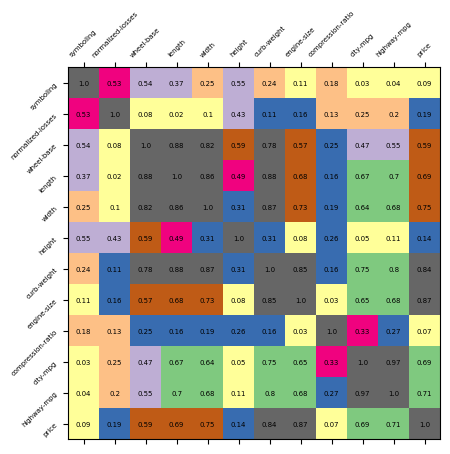

In [10]:
# correlation between target and features
df_corr = df.copy()
for x in df:
    if df[x].dtype not in (np.int64, np.float64):
        df_corr.drop(labels=x, axis=1, inplace=True)
df_corr_res = df_corr.corr()

plt.matshow(df_corr_res, cmap=plt.cm.Accent)
for x_pos in range(len(df_corr_res)):
    for y_pos in range(len(df_corr_res)):
        plt.text(x_pos, y_pos, np.abs(np.round(df_corr_res.iloc[x_pos,y_pos],2)),
                 va='center',ha='center',fontsize=5)
plt.xticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=5)
plt.yticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=5)
plt.minorticks_on
plt.show()

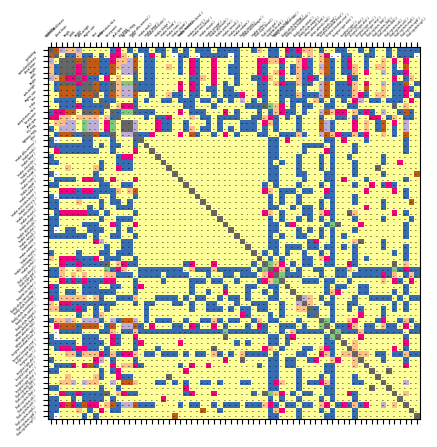

In [11]:
# correlation between target and features
df_corr = df_data.copy()
df_corr_res = df_corr.corr()

plt.matshow(df_corr_res, cmap=plt.cm.Accent)
for x_pos in range(len(df_corr_res)):
    for y_pos in range(len(df_corr_res)):
        plt.text(x_pos, y_pos, np.abs(np.round(df_corr_res.iloc[x_pos,y_pos],2)),
                 va='center',ha='center',fontsize=1)
plt.xticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=2)
plt.yticks(np.arange(0,len(df_corr_res.columns),1),labels=df_corr_res.columns,rotation=45,fontsize=2)
plt.minorticks_on
plt.show()

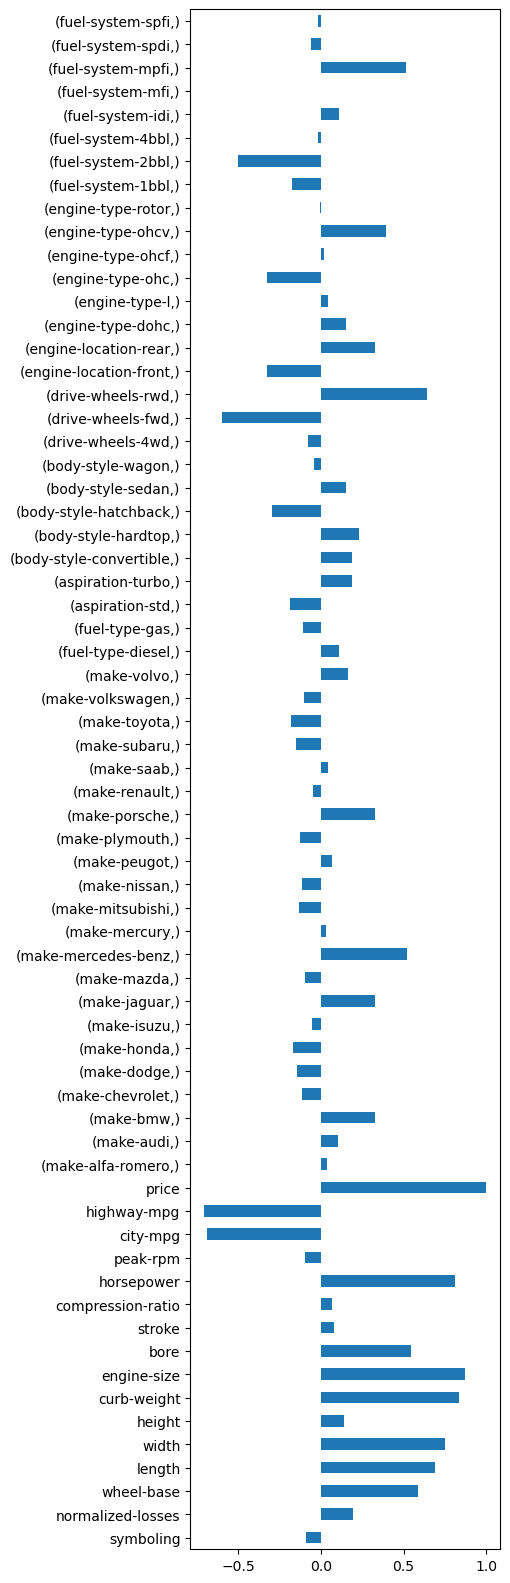

In [12]:
df_data.corr().loc["price"].plot(kind='barh',figsize=(4,20))
plt.show()

### drop columns with correlation value less than setting(0.2)

In [13]:
# drop columns have low correlation value
relation_lvl = 0.2

df_corrs = df_data.copy()
corr_col = abs(df_corrs.corr().loc["price"])
corr_drop_col = corr_col[corr_col < relation_lvl]
cols_drop_label = corr_drop_col.index.to_list()
df_corrs.drop(labels=cols_drop_label, axis=1, inplace=True)
df_corrs.columns

Index([              'wheel-base',                   'length',
                          'width',              'curb-weight',
                    'engine-size',                     'bore',
                     'horsepower',                 'city-mpg',
                    'highway-mpg',                    'price',
                    ('make-bmw',),           ('make-jaguar',),
          ('make-mercedes-benz',),          ('make-porsche',),
          ('body-style-hardtop',),  ('body-style-hatchback',),
            ('drive-wheels-fwd',),      ('drive-wheels-rwd',),
       ('engine-location-front',),  ('engine-location-rear',),
             ('engine-type-ohc',),      ('engine-type-ohcv',),
            ('fuel-system-2bbl',),      ('fuel-system-mpfi',)],
      dtype='object')

## data preprocessing - boxplot

<AxesSubplot:xlabel='fuel-type', ylabel='price'>

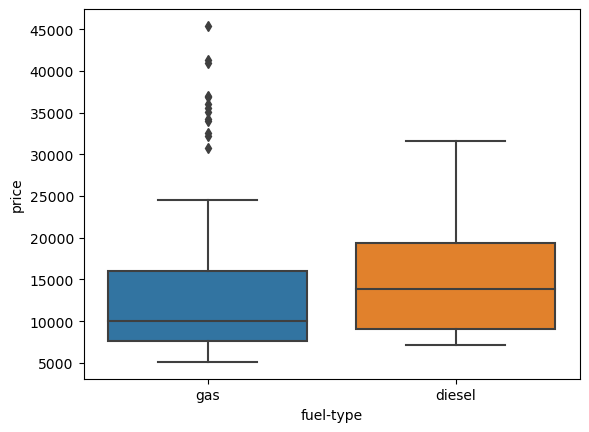

In [14]:
import seaborn as sns

sns.boxplot(y='price', x='fuel-type', data = df)

## data preprocessing - variance

In [15]:
# low variance means high stability
df.select_dtypes(include=np.number).var().astype('str')

symboling            1.5834687946406596
normalized-losses     1252.905986696231
wheel-base            37.14320501453129
length               152.13569971922544
width                4.4390887148416365
height                5.976896704595835
curb-weight            267533.755898724
engine-size          1718.5393084084524
compression-ratio    15.962133343185064
city-mpg              41.24151519629575
highway-mpg           46.37527707994674
price                 63280745.69962066
dtype: object

In [16]:
df["width"].describe()

count    202.000000
mean      65.903960
std        2.106915
min       60.300000
25%       64.125000
50%       65.500000
75%       66.825000
max       72.000000
Name: width, dtype: float64

# finding relations between features
1. pandas get_dummies will apply one-hot-encoding to each non-numerical feature, create dummy variables

In [17]:
# data manging first, transfer object into numerical data
from sklearn.impute import SimpleImputer
df_features = df.copy()

# transfer string into numeric number
# then replace missing data with median of series
col_list3 = ["bore","stroke","horsepower","peak-rpm"]
for col_name3 in col_list3:
    temp_series = trans_object_to_num(df_features,col_name3)
    df_features[col_name3] = temp_series
    df_features[col_name3].fillna(df_data[col_name3].median(),inplace=True)
df_features.shape

(202, 26)

## data preprocessing -heatmap

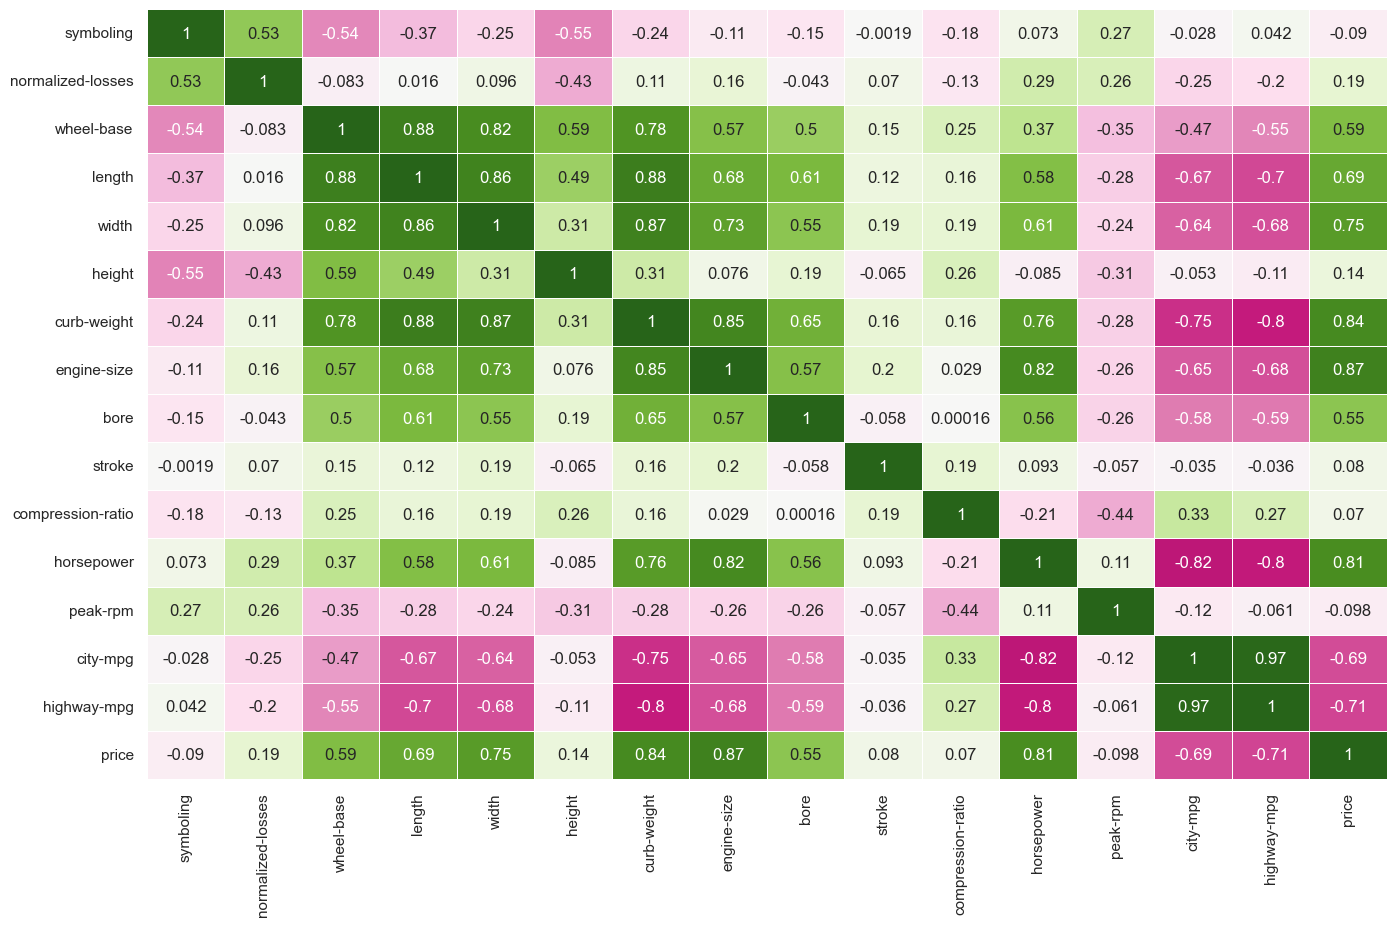

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(df_features.corr(), annot=True, lw=.5, center=0, cbar=False, cmap="PiYG")
plt.show()

## chi-square test
1. pandas <font color=sapphire><b>crosstab()</b></font> function
2. scipy <font color=sapphire><b>chi2_contingency</b></font> package

In [19]:
df_cat = df_features[['fuel-type','body-style']]
df_cat.sample(5)

,fuel-type,body-style
143,gas,wagon
199,diesel,sedan
149,gas,wagon
178,diesel,sedan
62,gas,sedan


In [20]:
crosstab = pd.crosstab(df_cat['fuel-type'],df_cat['body-style'])
crosstab

body-style,convertible,hardtop,hatchback,sedan,wagon
fuel-type,,,,,
diesel,0,1,1,15,3
gas,6,7,67,80,22


In [21]:
from scipy.stats import chi2_contingency

chi2_contingency(crosstab)

(9.953585564590208,
 0.04121682705941806,
 4,
 array([[ 0.59405941,  0.79207921,  6.73267327,  9.40594059,  2.47524752],
        [ 5.40594059,  7.20792079, 61.26732673, 85.59405941, 22.52475248]]))

## linear regression coef test

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# drop columns with missing values
df_features = df_features.dropna()

# get dummies for categorical features
df_features = pd.get_dummies(df_features, drop_first=True)
# X features
X = df_features.drop('price', axis=1)
# y target
y = df_features['price']
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# convert back to dataframe
X_train = pd.DataFrame(X_train, columns = X.columns.to_list())
X_test = pd.DataFrame(X_test, columns = X.columns.to_list())
# instantiate model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

(57,)


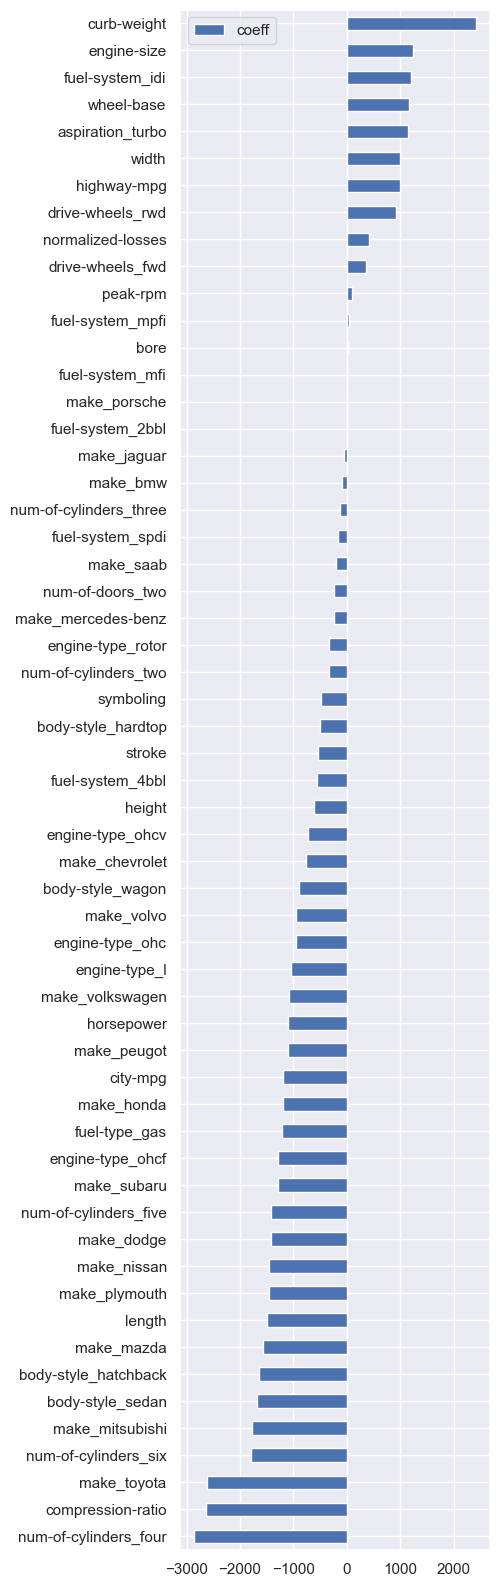

In [26]:
# feature coefficients
coeffs = model.coef_

# visualizing coefficients
index = X_train.columns.tolist()

(pd.DataFrame(data = coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
.plot(kind = 'barh', figsize = (4,20)))
print(coeffs.shape)

(54,)


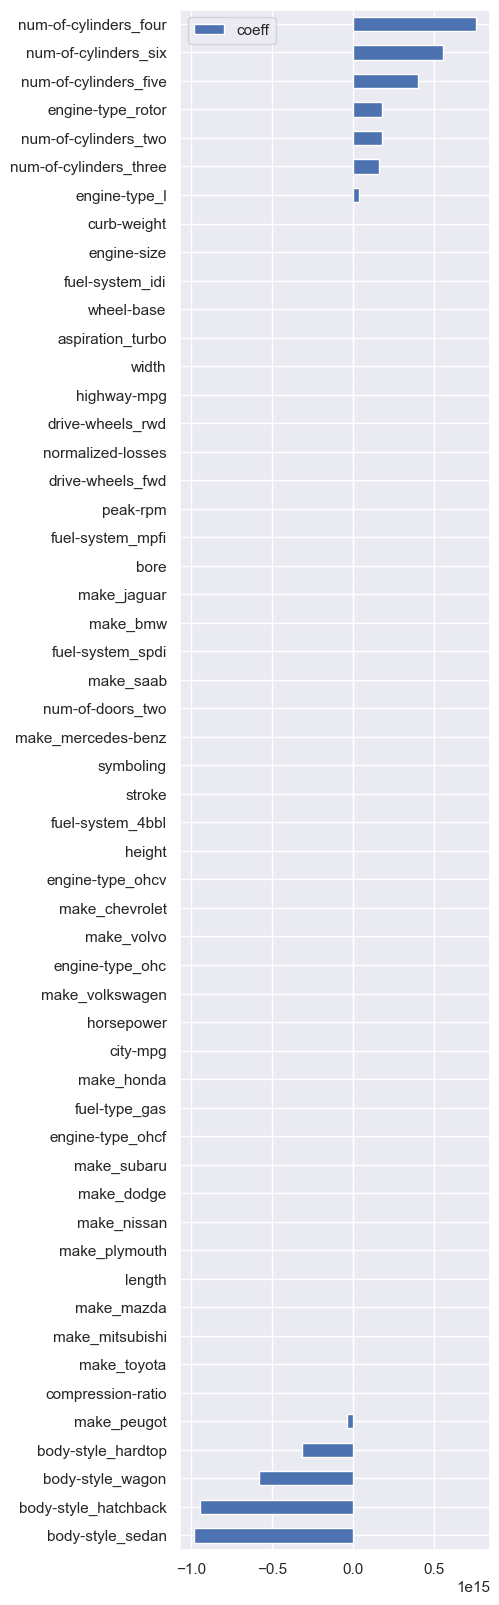

In [25]:
# filter variables near zero coefficient value
temp = pd.DataFrame(data = coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
temp = temp[(temp['coeff']>10) | (temp['coeff']< -10)]

# drop those features
cols_coeff = temp.index.to_list()
X_train2 = X_train[cols_coeff]
X_test2 = X_test[cols_coeff]

# instantiate model
model2 = LinearRegression()
model2.fit(X_train2, y_train)

# feature coefficients
coeffs2 = model2.coef_

# visualizing coefficients
index2 = X_train2.columns.tolist()

(pd.DataFrame(data = coeffs2, index = index2, columns = ['coeff']).sort_values(by = 'coeff')
.plot(kind = 'barh', figsize = (4,20)))
print(coeffs2.shape)

## p test

In [32]:
import statsmodels.api as sm

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     74.35
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           2.37e-66
Time:                        10:12:01   Log-Likelihood:                -1359.5
No. Observations:                 164   AIC:                             2827.
Df Residuals:                     110   BIC:                             2994.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
symboling                -14

## VIF
<font color=sapphire><b>variance_inflation_factor(exog, exog_idx)</b></font><br>

The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, <br>given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.

One recommendation is that if VIF is greater than 5, then the explanatory
variable given by exog_idx is highly collinear with the other explanatory
variables, and the parameter estimates will have large standard errors
because of this.

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# calculate VIF
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

# display VIFs in a table
index = X_train.columns.tolist()
vif_df = pd.DataFrame(vif, index = index, columns = ['vif']).sort_values(by = 'vif', ascending=False)
vif_df[vif_df['vif']<10]

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,vif
height,9.353943
make_bmw,9.225778
stroke,9.193095
make_mercedes-benz,9.176327
peak-rpm,8.750248
symboling,8.547891
engine-type_ohcv,7.504886
make_chevrolet,7.479141
body-style_hardtop,6.751380
fuel-system_4bbl,6.538773


## others

In [34]:
from sklearn.feature_selection import (SelectKBest, chi2, SelectPercentile, SelectFromModel, 
                                       SequentialFeatureSelector)

### select k best

In [46]:
# select K best features
X_best = SelectKBest(chi2, k=10).fit_transform(X.apply(lambda x: abs(x)),y)

# number of best features
X_best.shape

(164, 10)

### select percentile

In [44]:
# keep 75% top features
X_top = SelectPercentile(chi2, percentile = 75).fit_transform(np.abs(X),y)

# number of best features
X_top.shape

(164, 42)

### select from model

In [83]:
# implement algorithm
from sklearn.svm import LinearSVC
model_svc = LinearSVC(penalty= 'l1', C = 0.002, dual=False)
model_svc.fit(X,y)
# select features using the meta transformer
selector_sfm = SelectFromModel(estimator = model_svc, prefit=True)

X_new = selector_sfm.transform(X)

In [68]:
X_new.shape

(164, 3)

In [56]:
# names of selected features
feature_names = np.array(X.columns)
feature_names[selector_sfm.get_support()]

array(['normalized-losses', 'curb-weight', 'peak-rpm'], dtype=object)

### sequential feature selector

In [57]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

# instantiate model
model_rf = RandomForestClassifier(n_estimators=100, random_state=0)

# select features
selector_sfs = SequentialFeatureSelector(estimator=model_rf, n_features_to_select=10,
                                         direction='backward', cv=2)
selector_sfs.fit_transform(X,y)

array(['peak-rpm', 'highway-mpg', 'make_mitsubishi', 'num-of-doors_two',
       'body-style_hatchback', 'engine-type_ohcf', 'engine-type_ohcv',
       'num-of-cylinders_four', 'num-of-cylinders_two',
       'fuel-system_2bbl'], dtype=object)

In [58]:
# check names of features selected
feature_names = np.array(X.columns)
feature_names[selector_sfs.get_support()]

array(['peak-rpm', 'highway-mpg', 'make_mitsubishi', 'num-of-doors_two',
       'body-style_hatchback', 'engine-type_ohcf', 'engine-type_ohcv',
       'num-of-cylinders_four', 'num-of-cylinders_two',
       'fuel-system_2bbl'], dtype=object)

## PCA

Text(0, 0.5, 'Cumulative explained variance')

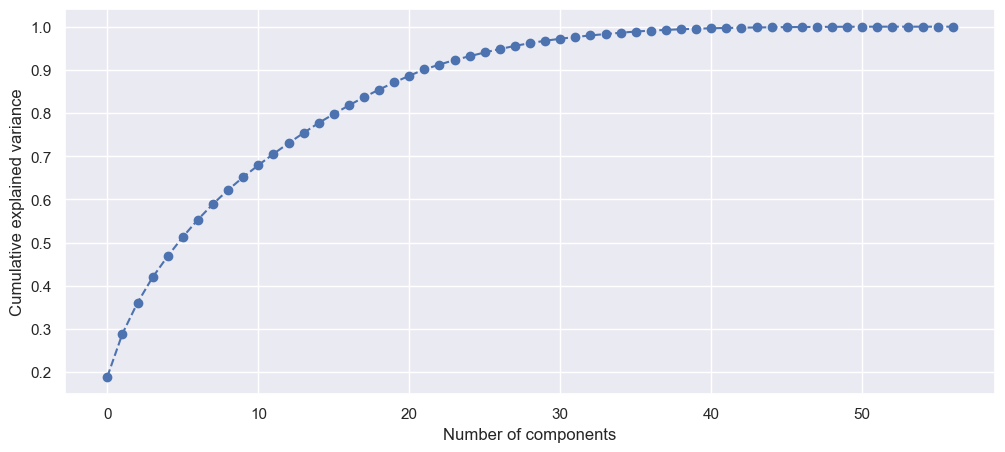

In [84]:
from sklearn.decomposition import PCA

# scaling data
X_scaled = scaler.fit_transform(X)
# fit PCA to data
pca = PCA()
pca.fit(X_scaled)
evr = pca.explained_variance_ratio_

# visualizing the variance explained by each principal components
plt.figure(figsize=(12, 5))
plt.plot(range(0, len(evr)), evr.cumsum(), marker="o", linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")